# Lab 5 - Grad Lab

## Question: How does a KNN model predict if a college can predict college completion for students? 

### Cleaning Data

#### Import Data

In [201]:
import pandas as pd
import warnings
warnings.filterwarnings("ignore")

grad_data = pd.read_csv('https://query.data.world/s/qpi2ltkz23yp2fcaz4jmlrskjx5qnp', encoding="cp1252")
grad_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3798 entries, 0 to 3797
Data columns (total 62 columns):
 #   Column                                Non-Null Count  Dtype  
---  ------                                --------------  -----  
 0   unitid                                3798 non-null   int64  
 1   chronname                             3798 non-null   object 
 2   city                                  3798 non-null   object 
 3   state                                 3798 non-null   object 
 4   level                                 3798 non-null   object 
 5   control                               3798 non-null   object 
 6   basic                                 3798 non-null   object 
 7   hbcu                                  94 non-null     object 
 8   flagship                              50 non-null     object 
 9   long_x                                3798 non-null   float64
 10  lat_y                                 3798 non-null   float64
 11  site             

#### Dropping Variables 

In [202]:
# variables that don't look predictive 
to_drop = list(range(39, 56))
to_drop.extend([27, 9, 10, 11, 28, 36, 60, 56])
grad_data1 = grad_data.drop(grad_data.columns[to_drop], axis=1)
drop_more = [0,2,3,6,8,11,12,14,15,18,21,23,29,32,33,34,35]
grad_data2 = grad_data1.drop(grad_data1.columns[drop_more], axis=1)
print(grad_data2.head())

                             chronname   level                 control hbcu  \
0               Alabama A&M University  4-year                  Public    X   
1  University of Alabama at Birmingham  4-year                  Public  NaN   
2                   Amridge University  4-year  Private not-for-profit  NaN   
3  University of Alabama at Huntsville  4-year                  Public  NaN   
4             Alabama State University  4-year                  Public    X   

   student_count  awards_per_value  exp_award_value  exp_award_percentile  \
0           4051              14.2           105331                    90   
1          11502              20.9           136546                    97   
2            322              29.9            58414                    30   
3           5696              20.9            64418                    61   
4           5356              11.6           132407                    96   

   ft_pct  fte_percentile  med_sat_value  aid_value  grad_100_

#### Variables to Factors 

In [203]:
import numpy as np
grad_data2.replace('NULL', np.nan, inplace=True)
grad_data2['hbcu'] = [1 if grad_data2['hbcu'][i]=='X' else 0 for i in range(len(grad_data2['hbcu']))]
grad_data2['hbcu'].value_counts()
grad_data2['hbcu'] = grad_data2.hbcu.astype('category')
grad_data2[['level', 'control']] = grad_data2[['level', 'control']].astype('category')
grad_data2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3798 entries, 0 to 3797
Data columns (total 20 columns):
 #   Column                Non-Null Count  Dtype   
---  ------                --------------  -----   
 0   chronname             3798 non-null   object  
 1   level                 3798 non-null   category
 2   control               3798 non-null   category
 3   hbcu                  3798 non-null   category
 4   student_count         3798 non-null   int64   
 5   awards_per_value      3798 non-null   float64 
 6   exp_award_value       3798 non-null   int64   
 7   exp_award_percentile  3798 non-null   int64   
 8   ft_pct                3794 non-null   float64 
 9   fte_percentile        3798 non-null   int64   
 10  med_sat_value         1337 non-null   float64 
 11  aid_value             3797 non-null   float64 
 12  grad_100_value        3467 non-null   float64 
 13  grad_100_percentile   3467 non-null   float64 
 14  grad_150_value        3467 non-null   float64 
 15  grad

#### Graphing Missing Values 

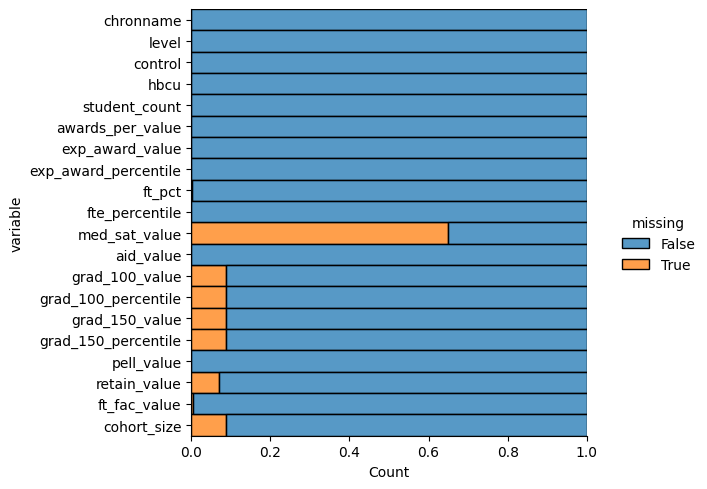

In [204]:
import seaborn as sns

sns.displot(
    data=grad_data2.isna().melt(value_name="missing"),
    y="variable",
    hue="missing",
    multiple="fill",
    aspect=1.25
)

#### Dropping Med_Sat_Value and Missing Values

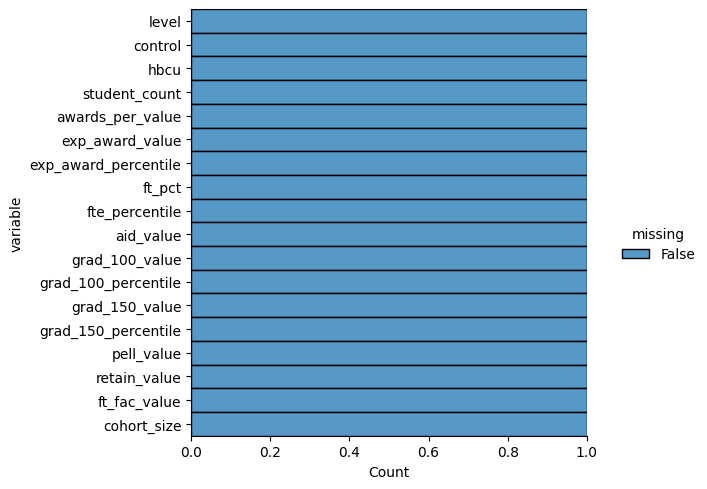

In [205]:
grad_data2 = grad_data2.drop(columns=['med_sat_value', 'chronname']) # drop object 
grad_data2.dropna(axis = 0, how = 'any', inplace = True)
sns.displot(
    data=grad_data2.isna().melt(value_name="missing"),
    y="variable",
    hue="missing",
    multiple="fill",
    aspect=1.25
)

### 2. Build a kNN model to predict your target variable using 3 nearest neighbors. Make sure it is a classification problem, meaning if needed changed the target variable.

#### Target Variable 

In [206]:
median_grad = grad_data2["grad_150_value"].median()
higher_threshold = median_grad * 1.10
grad_data2["grad_150_class"] = (grad_data2["grad_150_value"] >= higher_threshold).astype('category')
grad_data2.drop(columns=['grad_150_value'], inplace=True)

#### Normalize Numeric Values 

In [207]:
from sklearn import preprocessing

numeric_cols = grad_data2.select_dtypes(include=['int64', 'float64']).columns

scaler = preprocessing.MinMaxScaler()
d = scaler.fit_transform(grad_data2[numeric_cols])   # conduct data transformation
scaled_df = pd.DataFrame(d, columns=numeric_cols)  
grad_data2[numeric_cols] = scaled_df  
grad_data2.describe()

,student_count,awards_per_value,exp_award_value,exp_award_percentile,ft_pct,fte_percentile,aid_value,grad_100_value,grad_100_percentile,grad_150_percentile,pell_value,retain_value,ft_fac_value,cohort_size
count,3083.000000,3083.000000,3083.000000,3083.000000,3083.000000,3083.000000,3083.000000,3083.000000,3083.000000,3083.000000,3083.000000,3083.000000,3083.000000,3083.000000
mean,0.028538,0.168413,0.012989,0.521395,0.703992,0.516588,0.197336,0.286835,0.474713,0.494324,0.452812,0.667870,0.472318,0.042465
std,0.044812,0.074907,0.022193,0.286257,0.259193,0.288517,0.162857,0.231574,0.302494,0.292061,0.192148,0.158788,0.241401,0.060441
min,0.000000,0.000000,0.000000,0.000000,0.006237,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.004594,0.126340,0.006494,0.280000,0.476611,0.270000,0.092223,0.094000,0.210000,0.240000,0.315000,0.564500,0.281000,0.009613
50%,0.012327,0.156968,0.010044,0.530000,0.776507,0.530000,0.127307,0.231000,0.470000,0.490000,0.427000,0.672000,0.444000,0.023170
75%,0.033902,0.189127,0.015248,0.770000,0.937630,0.770000,0.254348,0.438000,0.740000,0.750000,0.575000,0.781000,0.646000,0.050622
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


#### Onehot Encode 

In [208]:
cat_cols = grad_data2.select_dtypes(include='category').columns

encoded = pd.get_dummies(grad_data2[cat_cols])
encoded.head()  

,level_2-year,level_4-year,control_Private for-profit,control_Private not-for-profit,control_Public,hbcu_0,hbcu_1,grad_150_class_False,grad_150_class_True
0,False,True,False,False,True,False,True,True,False
1,False,True,False,False,True,True,False,False,True
2,False,True,False,True,False,True,False,False,True
3,False,True,False,False,True,True,False,False,True
4,False,True,False,False,True,False,True,True,False


#### Drop Categorical and Join Encoded Variables 

In [209]:
grad_data2 = grad_data2.drop(cat_cols, axis=1)
grad_data2 = grad_data2.join(encoded)

In [210]:
grad_data2.dropna(axis = 0, how = 'any', inplace = True)
print(grad_data2.info())

<class 'pandas.core.frame.DataFrame'>
Index: 3083 entries, 0 to 3369
Data columns (total 23 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   student_count                   3083 non-null   float64
 1   awards_per_value                3083 non-null   float64
 2   exp_award_value                 3083 non-null   float64
 3   exp_award_percentile            3083 non-null   float64
 4   ft_pct                          3083 non-null   float64
 5   fte_percentile                  3083 non-null   float64
 6   aid_value                       3083 non-null   float64
 7   grad_100_value                  3083 non-null   float64
 8   grad_100_percentile             3083 non-null   float64
 9   grad_150_percentile             3083 non-null   float64
 10  pell_value                      3083 non-null   float64
 11  retain_value                    3083 non-null   float64
 12  ft_fac_value                    3083 no

#### Prevalence of Public College

In [211]:
print(grad_data2['grad_150_class_True'].value_counts()[1] / grad_data2['grad_150_class_True'].count())
# we have 43% chance of predicting the right control

0.43723645799545896


#### Train/Test Split

In [212]:
from sklearn.model_selection import train_test_split

train, test = train_test_split(grad_data2, test_size=0.4, stratify=grad_data2['grad_150_class_True'], random_state=99)
test, val = train_test_split(test, test_size=0.4, stratify=test['grad_150_class_True'], random_state=99)

#### Training Classifier 

In [213]:
import random
from sklearn.neighbors import KNeighborsClassifier
random.seed(99)  

X_train = train.drop(['grad_150_class_True'], axis=1).values
y_train = train['grad_150_class_True'].values

neigh = KNeighborsClassifier(n_neighbors=3)
neigh.fit(X_train, y_train)

KNeighborsClassifier(n_neighbors=3)

#### Evaluate Test Data Accuracy 

In [214]:
X_test = test.drop(['grad_150_class_True'], axis=1).values
y_test = test['grad_150_class_True'].values

print(neigh.score(X_test, y_test))

0.9986486486486487


### 3. Create a dataframe that includes the test target values, test predicted values, and test probabilities of the positive class.

#### Dataframe

In [215]:
from sklearn.metrics import accuracy_score

test_probs = neigh.predict_proba(X_test)
test_preds = neigh.predict(X_test)
test_probabilities = pd.DataFrame(test_probs, columns = ['grad_150_class_False','grad_150_class_True'])
final_model = pd.DataFrame({'actual_class': y_test.tolist(),
                           'pred_class': test_preds.tolist(),
                           'pred_prob': test_probabilities['grad_150_class_True']})
final_model.head()

,actual_class,pred_class,pred_prob
0,True,True,1.0
1,False,False,0.0
2,True,True,1.0
3,True,True,1.0
4,True,True,1.0


### 4. If you adjusted the k hyperparameter what do you think would happen to the threshold function? Would the confusion look the same at the same threshold levels or not? Why or why not?

If you increase k, the model is less sensitive to noise and fluctuation as it averages out across the neighbors. What you will then see is a smoother decision boundary, where the threshold function is also less sensitive to noise. If you decrease k, the threshold function is more sensitive to the small fluctuations in the data. There is more likeliness of over-fitting where the k is trying to capture all the small details of the data. For confusion matrix, it would not look the same at the same threshold levels as a higher k will produce less false positives as it will try to make safer predictions, but the likeliness of more false negatives may increase. A lower k may produce more false positives and less false negatives. 

### 5. Evaluate the results using the confusion matrix. Then "walk" through your question, summarize what concerns or positive elements do you have about the model as it relates to your question? 

#### Confusion Matrix for Final Model 

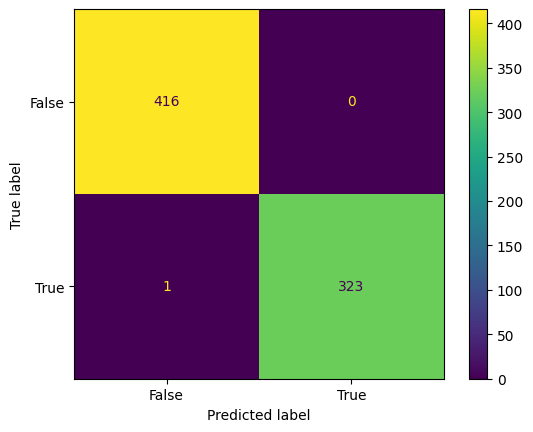

In [216]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

final_model.actual_class = final_model.actual_class.astype('category')
final_model.pred_class = final_model.pred_class.astype('category')

cm = confusion_matrix(final_model.actual_class, final_model.pred_class) 
disp=ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=neigh.classes_)  
disp.plot()

#### Probability Distribution Graph

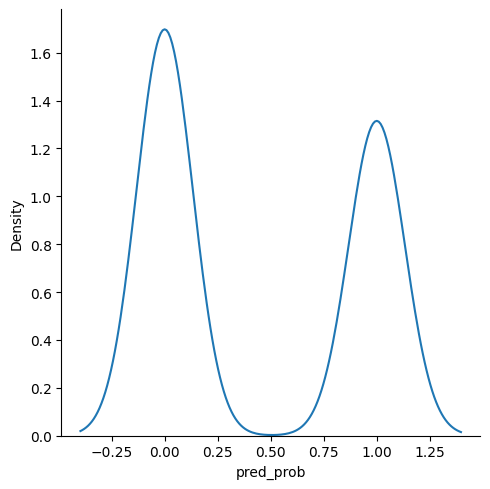

In [217]:
sns.displot(final_model, x="pred_prob", kind="kde")

#### Confusion Matrix Evaluation 

The confusion matrix shows only one False negative even after adjusting the thresholds. The model performs well with high accuracy and precision. The sensitivity and specificity are high considering the true positives and true negatives. 

#### Walk Through Question

Based on the question, we are trying to predict college completion for students. By classifying it with higher completion and lower completion, the confusion matrix shows that it is able to make the predictions for the right class with the ratio of true positive and true negatives to false positive and false negatives. This indicates the K neighbors have consistently deliver results of high accuracy. 

#### Positive Elements/Concerns

The positive element about this model is the high accuracy. From observing the confusion matrix, it seems to predict everything correctly with only one False negative. However, this high accuracy is concerning as well. The graph is over-fitting if it produces results that are basically perfect. This means the model is essentially memorizing the data for the college completion, instead of making real predictions. From observing the probability distribution model, we can see two distinct tall peaks for positive and negative class, meaning the model is predicting two classes with high confidence. The model is unable to generalize the dataset as there are two defined clusters within the dataset. The model is also over-fitting with the peaks having low variation, which means that it is very concentrated as certain values. 

### 6. Create Two Functions

#### Cleans and Split Data

In [218]:
def clean_and_split_data(df, target, test_size=0.4, random_state=99):
    #filtering 
    df = df[['level', 'control','hbcu','student_count','awards_per_value','exp_award_value','exp_award_percentile','ft_pct','fte_percentile','aid_value','pell_value', 'retain_value', 'ft_fac_value', 'cohort_size']]
    df.replace('NULL', np.nan, inplace=True)
    df['hbcu'] = [1 if df['hbcu'][i]=='X' else 0 for i in range(len(df['hbcu']))]
    df['hbcu'].value_counts()
    df['hbcu'] = df.hbcu.astype('category')
    df[['level', 'control']] = df[['level', 'control']].astype('category')

    # Onehot encode and normalize
    cat_cols = grad_data2.select_dtypes(include='category').columns
    cat_cols = ['level', 'control', target]  
    df[cat_cols] = df[cat_cols].astype('category') 
    numeric_cols = df.select_dtypes(include=['int64', 'float64']).columns
    scaler = preprocessing.MinMaxScaler()
    df[numeric_cols] = scaler.fit_transform(df[numeric_cols])
    encoded = pd.get_dummies(df[cat_cols]) 
    df = df.drop(cat_cols, axis=1).join(encoded)
    df.dropna(axis = 0, how = 'any', inplace = True)
    train, test = train_test_split(df, test_size=test_size, stratify=df[f'{target}_1'], random_state=random_state)

    X_train = train.drop([f'{target}_1'], axis=1).values
    y_train = train[f'{target}_1'].values

    X_test = test.drop([f'{target}_1'], axis=1).values
    y_test = test[f'{target}_1'].values

    return X_train, y_train, X_test, y_test

#### Train and Test model

In [219]:
def train_and_test(k, X_train, y_train, X_test, y_test, threshold, target):
    
    neigh = KNeighborsClassifier(n_neighbors=k)
    neigh.fit(X_train, y_train)

    score = neigh.score(X_test, y_test)
    
    test_probs = neigh.predict_proba(X_test)
    test_preds = neigh.predict(X_test)
    test_probabilities = pd.DataFrame(test_probs, columns = [f'{target}_0',f'{target}_1'])
    final_model = pd.DataFrame({'actual_class': y_test.tolist(),
                           'pred_class': test_preds.tolist(),
                           'pred_prob': test_probabilities[f'{target}_1']})
    
    final_model.actual_class = final_model.actual_class.astype('category')
    final_model.pred_class = final_model.pred_class.astype('category')

    def adjust_thres(x, y, z): # Adjusting Threshold Function
        thres = pd.DataFrame({'new_preds': [1 if i > y else 0 for i in x]})
        thres.new_preds = thres.new_preds.astype('category')
        con_mat = confusion_matrix(z, thres)
        return con_mat
    
    con_mat = adjust_thres(final_model.pred_prob, threshold, final_model.actual_class)
    return score, con_mat

### 7. How well does the model perform? Did the interaction of the adjusted thresholds and k values help the model? Why or why not? 

#### Choosing Best k

In [220]:
def chooseK(k, X_train, y_train, X_test, y_test):
    random.seed(1)
    print("calculating... ", k, "k")   
    class_knn = KNeighborsClassifier(n_neighbors=k)
    class_knn.fit(X_train, y_train)
    
    accu = class_knn.score(X_test, y_test)
    return accu

#### Plotting K

calculating...  1 k
calculating...  3 k
calculating...  5 k
calculating...  7 k
calculating...  9 k
calculating...  11 k
calculating...  13 k
calculating...  15 k
calculating...  17 k
calculating...  19 k
calculating...  21 k


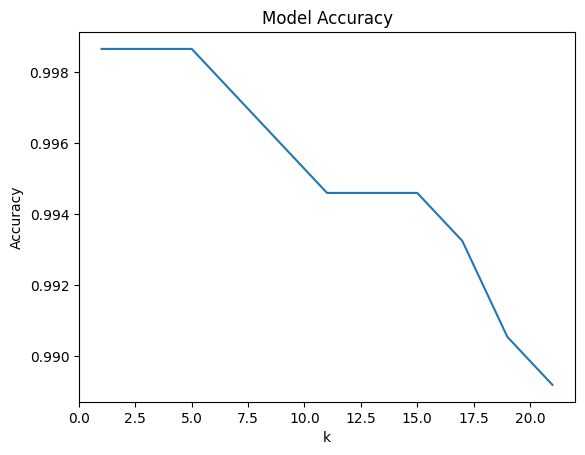

In [221]:
from matplotlib import pyplot as plt

test = pd.DataFrame({'k':list(range(1,22,2)), 
                     'accu':[chooseK(i, X_train, y_train, X_test, y_test) for i in list(range(1, 22, 2))]})
test = test.sort_values(by=['accu'], ascending=False)
plt.plot(test['k'], test['accu'])
plt.xlabel('k')
plt.ylabel('Accuracy')
plt.title('Model Accuracy')
plt.show()

#### Setting k = 19

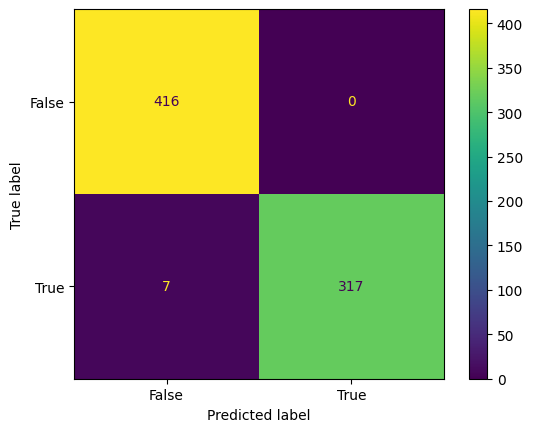

In [222]:
neigh = KNeighborsClassifier(n_neighbors=19)
neigh.fit(X_train, y_train)

score = neigh.score(X_test, y_test)

test_probs = neigh.predict_proba(X_test)
test_preds = neigh.predict(X_test)
test_probabilities = pd.DataFrame(test_probs, columns = ['grad_150_class_False','grad_150_class_True'])
final_model = pd.DataFrame({'actual_class': y_test.tolist(),
                           'pred_class': test_preds.tolist(),
                           'pred_prob': test_probabilities['grad_150_class_True']})

final_model.actual_class = final_model.actual_class.astype('category')
final_model.pred_class = final_model.pred_class.astype('category')

cm = confusion_matrix(final_model.actual_class, final_model.pred_class) 
disp=ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=neigh.classes_)  
disp.plot()

#### Adjusting Threshold

In [223]:
def adjust_thres(x, y, z): # Adjusting Threshold Function
    thres = pd.DataFrame({'new_preds': [1 if i > y else 0 for i in x]})
    thres.new_preds = thres.new_preds.astype('category')
    con_mat = confusion_matrix(z, thres)  
    print(con_mat)

#### Increashing Threshold 

In [224]:
adjust_thres(final_model.pred_prob, .90, final_model.actual_class)

[[416   0]
 [ 18 306]]


#### Decreasing Threshold 

In [225]:
adjust_thres(final_model.pred_prob, .1, final_model.actual_class)

[[398  18]
 [  0 324]]


With an accuracy of 0.99, the model performed well overall. Setting the k at a larger value allows it to make more general assumption on the dataset, instead of just memorizing the data. It will be able to average out the the points and smoothen the decision boundary within the neighbors to make actual predictions. With adjusting the threshold, there are changes in false positives and false negatives that helped adjust the precision and sensitivity as well. A threshold of 0.9 shows it tries to be safe, which lead to less false positives. On the other hand, a threshold of 0.1 is more audacious and made more false positive guesses. 

### 8. Choose another variable as the target in the dataset and create another kNN model using the two functions you created in step 7

#### New Target Variable: hbcu (Historically Black Colleges and Universities)

calculating...  1 k
calculating...  3 k
calculating...  5 k
calculating...  7 k
calculating...  9 k
calculating...  11 k
calculating...  13 k
calculating...  15 k
calculating...  17 k
calculating...  19 k
calculating...  21 k


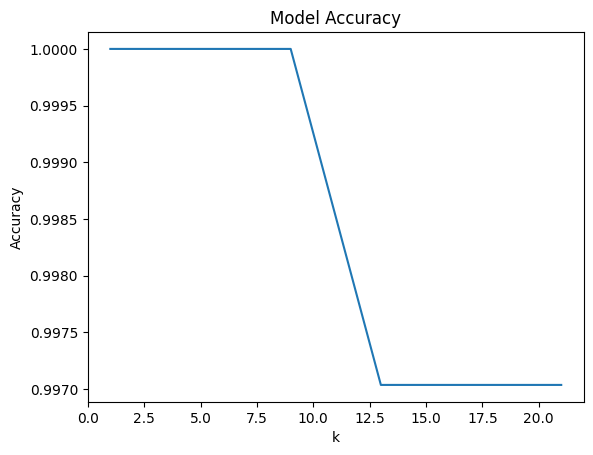

In [226]:
X_train, y_train, X_test, y_test = clean_and_split_data(grad_data, target = 'hbcu')
test = pd.DataFrame({'k':list(range(1,22,2)), 
                     'accu':[chooseK(i, X_train, y_train, X_test, y_test) for i in list(range(1, 22, 2))]})
test = test.sort_values(by=['accu'], ascending=False)
plt.plot(test['k'], test['accu'])
plt.xlabel('k')
plt.ylabel('Accuracy')
plt.title('Model Accuracy')
plt.show()


In [227]:
X_train, y_train, X_test, y_test = clean_and_split_data(grad_data, target = 'hbcu')
score, conmat = train_and_test(13, X_train, y_train, X_test, y_test, threshold = 0.9, target = 'hbcu')
print("Score: " , score)
print("Confusion Matrix: ", conmat)

Score:  0.9970348406226834
Confusion Matrix:  [[1312    0]
 [   4   33]]
